## Python Data fitting with various functions - HW 11 part 2 
Due Friday Nov 10, 2023


Dowload the data "miniDR17.fits" from the TCU Online Week 12:<br>
<i>NOTE: it is a large-ish file and may take a while.</i>

**However, this is a small version of the full science data file (4 GB) which can be found at:**<br>
https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits


You will be using the same data "miniDR17.fits" from the TCU Online Week 12:<br>

Remember you need to remove Identified bad data, 
however data that are just bad in one quantity may remain
Use masking to remove any remaining bad values (typically 9999 or -9999 in this file, <b>but remember to remove Outliers!!!!  If you are not sure, ask!!!</b>). 

In [24]:
from matplotlib import pyplot as plt
import numpy as np
import math
from astropy.io import fits 
import scipy.optimize as opt

# POTENTIAL FITTING FUNCTIONS
def linear(x,m,b):
    return m*x+b

def poly2(x,a,b,c):
    return a*(x**2)+(b*x)+c

def poly3(x,a,b,c,d):
    return (a*(x**3))+(b*(x**2))+(c*x)+d

def cosfit (x,a,b,c,d):
    return a*np.cos(b*x + c) + d

def exponential(x,a,b,c,d):
    return a*np.exp(b*x + c) + d

def logfit(x,a,b,c,d):
    return a*np.log(b*x + c) + d


# Monte Carlo-version of 2 parameter Curve Fit that can use BOTH x and Y errors
def mcFit2(func, x, y, x_err=0.1, y_err=0.1, p0=[0,0]):
    slope = list()
    y_ints = list()
    iters = 50 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        slope.append(popt[0])
        y_ints.append(popt[1])
    return (np.median(slope),np.median(y_ints))


# Monte Carlo-version of 3 parameter Curve Fit that can use BOTH x and Y errors
def mcFit3(func, x, y, x_err=0.1, y_err=0.1,p0=[1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    iters = 50 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
    return (np.median(paramA),np.median(paramB),np.median(paramC))

# Monte Carlo-version of 4 parameter Curve Fit that can use BOTH x and Y errors
def mcFit4(func, x, y, x_err=0.1, y_err=0.1, p0=[1,1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    paramD = list()
    iters = 50 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
        paramD.append(popt[3])
    return (np.median(paramA),np.median(paramB),np.median(paramC),np.median(paramD))


In [2]:
# READ IN FITS FILES
star_hdus = fits.open('miniDR17.fits')
star = star_hdus[1].data
print(star_hdus[1].columns)
star_hdus.close()

ColDefs(
    name = 'APOGEE_ID'; format = '30A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'TEFF'; format = 'E'
    name = 'TEFF_ERR'; format = 'E'
    name = 'LOGG'; format = 'E'
    name = 'LOGG_ERR'; format = 'E'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'SNR'; format = 'E'
    name = 'VHELIO_AVG'; format = 'E'
    name = 'VERR'; format = 'E'
    name = 'FE_H'; format = 'E'
    name = 'FE_H_ERR'; format = 'E'
    name = 'O_FE'; format = 'E'
    name = 'O_FE_ERR'; format = 'E'
    name = 'NI_FE'; format = 'E'
    name = 'NI_FE_ERR'; format = 'E'
    name = 'NVISITS'; format = 'J'
    name = 'VSCATTER'; format = 'E'
    name = 'ASPCAPFLAG'; format = 'K'
    name = 'STARFLAG'; format = 'K'
    name = 'EXTRATARG'; format = 'J'
    name = 'GAIA_PARALLAX'; format = 'E'
    name = 'GAIA_PARALLAX_ERROR'; for

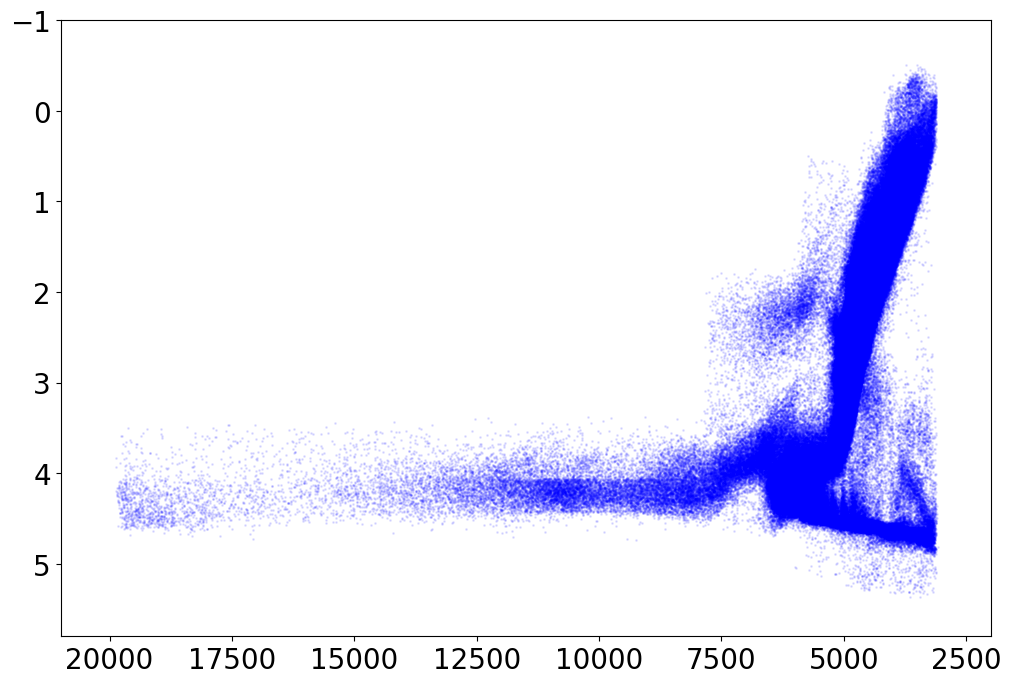

In [3]:
# TWO BITWISE FLAGS FOR BAD DATA - THESE REMOVE IDENTIFIED BAD DATA            
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0)
good = np.where(gd)[0]


# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter((star['TEFF'][good]),star['LOGG'][good],s=1,c='b',alpha=0.1)

ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.set_xlim(21000,2000)
ax.set_ylim(5.8,-1)

plt.show()

## DATA FIT 1

Fit a linear, polynomial (poly2), and a polynomial (poly3) functions and to the following selections of the data:
1. Select stars only with with $ GLAT > 20$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

2.3286047 0.0053666024 0.95789 -2.4686
POLY2: -0.074, -0.317, 0.048
POLY3: 0.075, 0.093, -0.262,0.045


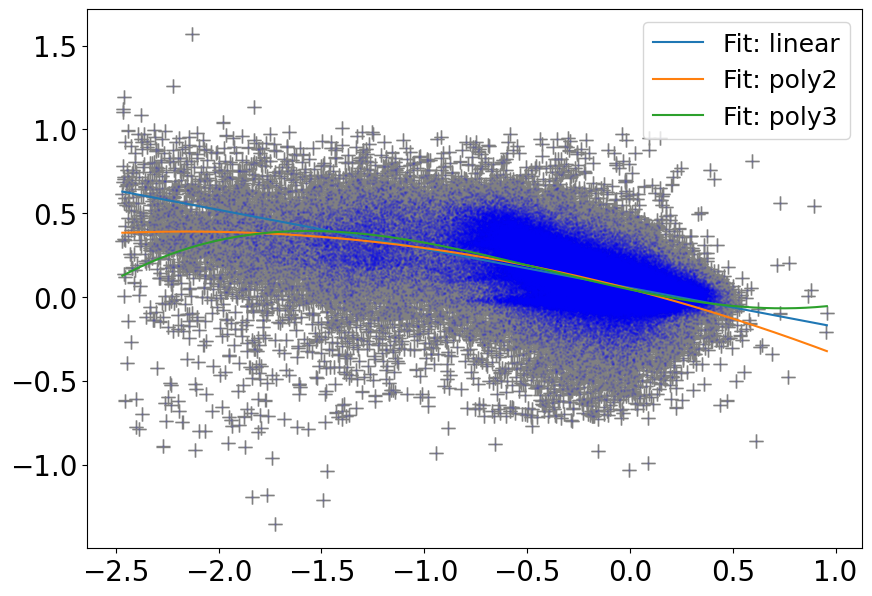

In [41]:
# FITTING - ANTHONY GERG
# --------------------------------------------
# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**23        
suspectbits = 2**16    
#=================================================================================
# Make the Mask

# GLAT >  20 and other 'bad' data.

ct1_ag = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     ((star['GLAT'] > 20)) & \
     (~np.isnan(star['FE_H'])==True) & \
     (~np.isnan(star['O_FE'])==True)
cut1_ag = np.where(ct1_ag)[0]
print(np.max(star['O_FE_ERR'][cut1_ag]),np.min(star['O_FE_ERR'][cut1_ag]), np.max(star['FE_H'][cut1_ag]),np.min(star['FE_H'][cut1_ag]), )
#=================================================================================
## Linear Fit
slope, intercept = mcFit2(linear, star['FE_H'][cut1_ag], star['O_FE'][cut1_ag], star['FE_H'][cut1_ag]/1000, \
                          star['O_FE'][cut1_ag]/1000, p0=[0,0])
 
#=================================================================================
## POLY2 FIT (3 parameter)
polyA, polyB, polyC,  = mcFit3(poly2, star['FE_H'][cut1_ag], star['O_FE'][cut1_ag], star['FE_H'][cut1_ag]/1000, \
                         star['O_FE'][cut1_ag]/1000,p0=[600,1,1])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

#=================================================================================
## POLY3 FIT (4 parameters)
bigpolyA, bigpolyB, bigpolyC, bigpolyD  = mcFit4(poly3, star['FE_H'][cut1_ag], star['O_FE'][cut1_ag], star['FE_H'][cut1_ag]/1000,  \
                         star['O_FE'][cut1_ag]/1000,p0=[1,1,1,1])
print(f'POLY3: {bigpolyA:.3f}, {bigpolyB:.3f}, {bigpolyC:.3f},{bigpolyD:.3f}')

#=================================================================================
# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['FE_H'][cut1_ag],star['O_FE'][cut1_ag],s=1,c='b',alpha=0.1)
ax1.errorbar((star['FE_H'][cut1_ag]),star['O_FE'][cut1_ag], xerr=(star['FE_H_ERR'][cut1_ag]/1000), yerr=abs(star['O_FE_ERR'][cut1_ag]/1000), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(np.min(star['FE_H'][cut1_ag]),np.max(star['FE_H'][cut1_ag]),1000)

#=================================================================================
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC), label='Fit: poly2')
#poly3 fit
ax1.plot(x_plot,poly3(x_plot, bigpolyA, bigpolyB, bigpolyC, bigpolyD), label='Fit: poly3')

plt.legend(loc='best', fontsize=18)
plt.show()


#What are the best-fit values of the parameters?
#Which fucntion fits the data best?
#Is there a second population? (Can you fit outliers with a reasonable linear trend?)
#1) Best fit values
#POLY2: -0.074, -0.317, 0.048
#POLY3: 0.075, 0.093, -0.262,0.045
#2) Function fits best?
#Poly three definetily fits the data the best
#3) Second fit?
# There is no second population

## DATA FIT 2

Fit a linear, polynomial (poly2), and a polynomial (poly3) functions and to the following selections of the data:
2. Select stars only with with $-1< GLAT < 1$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

1.2488226 0.0062261755 0.6565 -2.4593
POLY2: -0.020, -0.146, 0.041
POLY3: 0.091, 0.131, -0.131,0.033


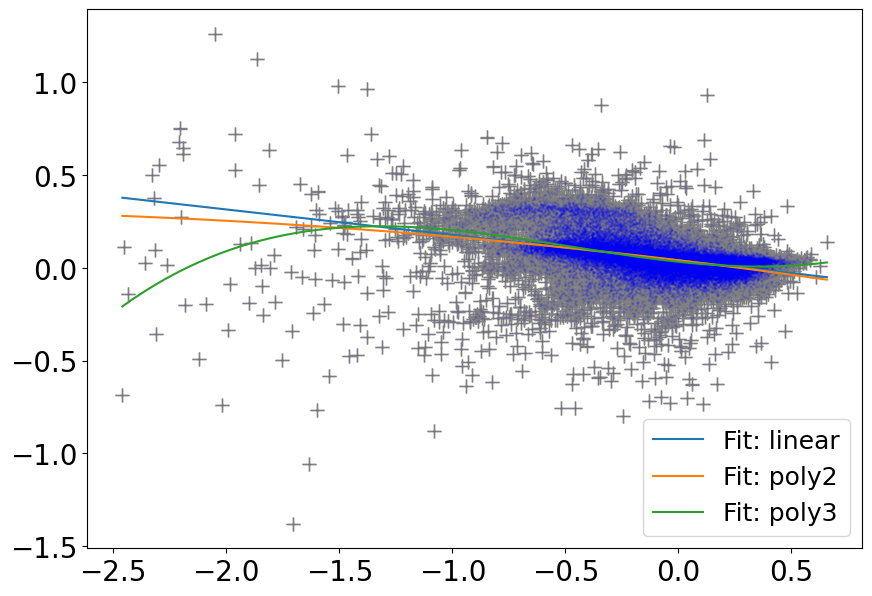

In [29]:
# FITTING - ANTHONY GERG
# --------------------------------------------
# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**23        
suspectbits = 2**16    
#=================================================================================
# Make the Mask

# GLAT >  20 and other 'bad' data.

ct1_ag = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     ((star['GLAT'] > -1)) & \
     ((star['GLAT'] < 1))  & \
     (~np.isnan(star['FE_H'])==True) & \
     (~np.isnan(star['O_FE'])==True)
cut1_ag = np.where(ct1_ag)[0]
print(np.max(star['O_FE_ERR'][cut1_ag]),np.min(star['O_FE_ERR'][cut1_ag]), np.max(star['FE_H'][cut1_ag]),np.min(star['FE_H'][cut1_ag]), )
#=================================================================================
## Linear Fit
slope, intercept = mcFit2(linear, star['FE_H'][cut1_ag], star['O_FE'][cut1_ag], star['FE_H'][cut1_ag]/1000, \
                          star['O_FE'][cut1_ag]/1000, p0=[0,0])
 
#=================================================================================
## POLY2 FIT (3 parameter)
polyA, polyB, polyC,  = mcFit3(poly2, star['FE_H'][cut1_ag], star['O_FE'][cut1_ag], star['FE_H'][cut1_ag]/1000, \
                         star['O_FE'][cut1_ag]/1000,p0=[600,1,1])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

#=================================================================================
## POLY3 FIT (4 parameters)
bigpolyA, bigpolyB, bigpolyC, bigpolyD  = mcFit4(poly3, star['FE_H'][cut1_ag], star['O_FE'][cut1_ag], star['FE_H'][cut1_ag]/1000,  \
                         star['O_FE'][cut1_ag]/1000,p0=[1,1,1,1])
print(f'POLY3: {bigpolyA:.3f}, {bigpolyB:.3f}, {bigpolyC:.3f},{bigpolyD:.3f}')

#=================================================================================
# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['FE_H'][cut1_ag],star['O_FE'][cut1_ag],s=1,c='b',alpha=0.1)
ax1.errorbar((star['FE_H'][cut1_ag]),star['O_FE'][cut1_ag], xerr=(star['FE_H_ERR'][cut1_ag]/1000), yerr=abs(star['O_FE_ERR'][cut1_ag]/1000), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(np.min(star['FE_H'][cut1_ag]),np.max(star['FE_H'][cut1_ag]),1000)

#=================================================================================
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC), label='Fit: poly2')
#poly3 fit
ax1.plot(x_plot,poly3(x_plot, bigpolyA, bigpolyB, bigpolyC, bigpolyD), label='Fit: poly3')

plt.legend(loc='best', fontsize=18)
plt.show()

#What are the best-fit values of the parameters?
#Which fucntion fits the data best?
#Is there a second population? (Can you fit outliers with a reasonable linear trend?)
#1) Best fit values
#POLY2: -0.020, -0.147, 0.041
#POLY3: 0.091, 0.131, -0.131,0.033
#2) Function fits best?
#Poly three definetily fits the data the best again
#3) Second fit?
# There is no second population

## DATA FIT 3

Fit a linear, polynomial (poly3), and a exponetial functions and to the following selections of the data:
3. Select stars only with with $340 < GLON < 360$ <br>
   __Fit TEFF,  (TEFF\_ERR)  vs.  LOGG (LOGG\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

19869.988 3068.0737 5.3110294 -0.32798845
LINEAR: 0.000, 0.348
POLY2: -0.000, 0.001, -1.986
POLY3: 0.000, -0.000, 0.002,-4.057


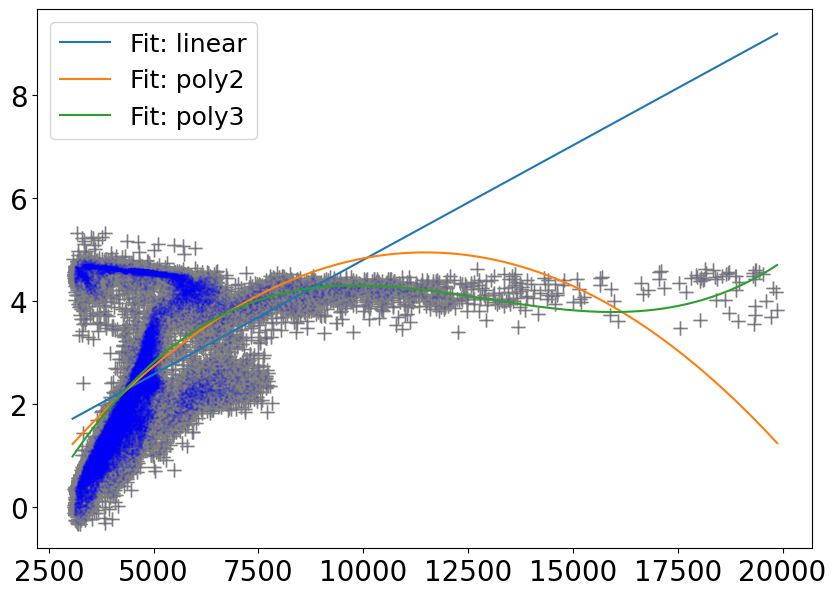

In [38]:
# FITTING - ANTHONY GERG
# --------------------------------------------
# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**23        
suspectbits = 2**16    
#=================================================================================
# Make the Mask

# GLAT >  20 and other 'bad' data.

ct1_ag = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     ((star['GLON'] > 340)) & \
     ((star['GLON'] < 360)) & \
     (~np.isnan(star['TEFF'])==True) & \
     (~np.isnan(star['LOGG'])==True)
cut1_ag = np.where(ct1_ag)[0]
print(np.max(star['TEFF'][cut1_ag]),np.min(star['TEFF'][cut1_ag]), np.max(star['LOGG'][cut1_ag]),np.min(star['LOGG'][cut1_ag]), )
#=================================================================================
## Linear Fit
slope, intercept = mcFit2(linear, star['TEFF'][cut1_ag], star['LOGG'][cut1_ag], star['TEFF'][cut1_ag]/1000, \
                          star['LOGG'][cut1_ag]/1000, p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}') 
#=================================================================================
## POLY2 FIT (3 parameter)
polyA, polyB, polyC,  = mcFit3(poly2, star['TEFF'][cut1_ag], star['LOGG'][cut1_ag], star['TEFF'][cut1_ag]/1000, \
                         star['LOGG'][cut1_ag]/1000,p0=[600,1,1])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')


#=================================================================================
## POLY3 FIT (4 parameters)
bigpolyA, bigpolyB, bigpolyC, bigpolyD  = mcFit4(poly3, star['TEFF'][cut1_ag], star['LOGG'][cut1_ag], star['TEFF'][cut1_ag]/1000,  \
                         star['LOGG'][cut1_ag]/1000,p0=[10, 1, 2500, 0])
print(f'POLY3: {bigpolyA:.3f}, {bigpolyB:.3f}, {bigpolyC:.3f},{bigpolyD:.3f}')

#=================================================================================
# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['TEFF'][cut1_ag],star['LOGG'][cut1_ag],s=1,c='b',alpha=0.1)
ax1.errorbar((star['TEFF'][cut1_ag]),star['LOGG'][cut1_ag], xerr=(star['TEFF_ERR'][cut1_ag]/1000),
             yerr=abs(star['LOGG_ERR'][cut1_ag]/1000), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(np.min(star['TEFF'][cut1_ag]),np.max(star['TEFF'][cut1_ag]),1000)

#=================================================================================
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC), label='Fit: poly2')
#poly3 fit
ax1.plot(x_plot,poly3(x_plot, bigpolyA, bigpolyB, bigpolyC, bigpolyD), label='Fit: poly3')

plt.legend(loc='best', fontsize=18)
plt.show()
#What are the best-fit values of the parameters?
#Which fucntion fits the data best?
#Is there a second population? (Can you fit outliers with a reasonable linear trend?)
#1) Best fit values
#LINEAR: 0.000, 0.348
#POLY2: -0.000, 0.001, -1.986
#POLY3: 0.000, -0.000, 0.002,-4.057
#2) Function fits best?
#Poly3 is the best fit(I couldn't get exponential to even run, so I instead put poly2 in)
#3) Second fit?
# There is a second population(the part the is outcropping on the middle left) so another fit would be best

## DATA FIT 4

Fit  a linear, a logfit, and a polynomial (poly2) functions and to the following selections of the data:
4. Select stars only with with $DEC < -50$ and $50 < RA < 120$ <br>
   __Fit TEFF,  (TEFF\_ERR)   vs.  (J - K) (J\_ERR, K\_ERR)__<br>
<br>
NOTE: you will have to create a (J-K) error:  JK_ERR = np.sqrt( J\_ERR^2 + K\_ERR^2 )<br> 

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

19697.701 3119.8591 22.676517 7.498401
LINEAR: -0.000, 17.725
POLY2: 0.000, -0.001, 19.398


C:\Users\gergy\AppData\Local\Temp\ipykernel_17436\3472178592.py:24: RuntimeWarning: invalid value encountered in log
  return a*np.log(b*x + c) + d


logfit: -2.109, 0.799, -995.134,32.087


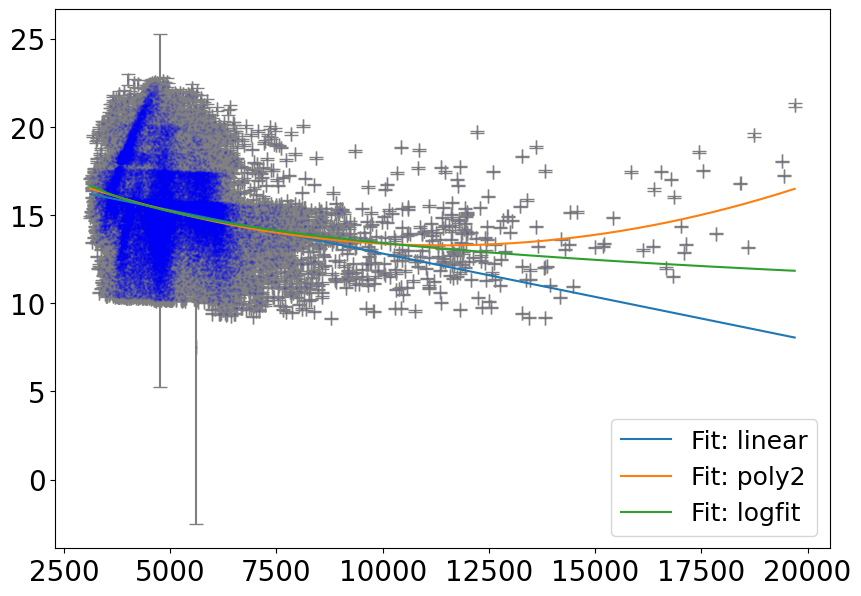

In [8]:
# FITTING - ANTHONY GERG
# --------------------------------------------
# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**23        
suspectbits = 2**16

#=================================================================================
# Make the Mask

# GLAT >  20 and other 'bad' data.

ct1_ag = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     ((star['DEC'] < -50)) & \
     ((star['RA'] > 50)) & \
     ((star['RA'] < 120)) & \
     (~np.isnan(star['TEFF'])==True) & \
     (~np.isnan(star['J_ERR'])==True) & \
     (~np.isnan(star['K_ERR'])==True) & (~np.isnan(star['J'])==True) & (~np.isnan(star['K'])==True) 
cut1_ag = np.where(ct1_ag)[0]
JK_ERR = np.sqrt(star['J_ERR'][cut1_ag]**2 + (star['K_ERR'][cut1_ag])**2)
JK = np.sqrt((star['J'][cut1_ag])**2+ (star['K'][cut1_ag])**2)
print(np.max(star['TEFF'][cut1_ag]),np.min(star['TEFF'][cut1_ag]), np.max(JK),np.min(JK) )
#=================================================================================
## Linear Fit
slope, intercept = mcFit2(linear, star['TEFF'][cut1_ag], JK, star['TEFF'][cut1_ag]/1000, \
                          JK/1000, p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}') 
#=================================================================================
## POLY2 FIT (3 parameter)
polyA, polyB, polyC,  = mcFit3(poly2, star['TEFF'][cut1_ag], JK, star['TEFF'][cut1_ag]/1000, \
                         JK/1000,p0=[600,1,1])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

#=================================================================================
## LOGFIT FIT (4 parameters)
bigpolyA, bigpolyB, bigpolyC, bigpolyD  = mcFit4(logfit, star['TEFF'][cut1_ag], JK, star['TEFF'][cut1_ag]/1000,  \
                         JK/1000,p0=[1,1,1,19])
print(f'logfit: {bigpolyA:.3f}, {bigpolyB:.3f}, {bigpolyC:.3f},{bigpolyD:.3f}')

#=================================================================================
# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['TEFF'][cut1_ag],JK,s=1,c='b',alpha=0.1)
ax1.errorbar((star['TEFF'][cut1_ag]),JK, xerr=abs(star['TEFF_ERR'][cut1_ag]/1000),
             yerr=abs(JK_ERR), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(np.min(star['TEFF'][cut1_ag]),np.max(star['TEFF'][cut1_ag]),1000)

#=================================================================================
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC), label='Fit: poly2')
#poly3 fit
ax1.plot(x_plot,logfit(x_plot, bigpolyA, bigpolyB, bigpolyC, bigpolyD), label='Fit: logfit')

plt.legend(loc='best', fontsize=18)
plt.show()
#1) Best fit values
#LINEAR: -0.000, 17.725
#POLY2: 0.000, -0.001, 19.398
#POLY3(logfit): -2.110, 0.793, -987.359,32.070
#2) Function fits best?
#Poly2 is the best fit for this data
#3) Second fit?
# You cannot fit a second population

## DATA FIT 5

Fit  a linear, a polynomial (poly3), and a cosfit functions and to the following selections of the data:
5. Select stars only with with $-10< GLAT < 10$<br>
   __Fit GLON  vs.  VHEILO\_AVG (VERR)__<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

359.99983180964705 8.826053718280491e-05 1034.152 -1012.1443
lin: -0.001, -3.966
cos: -49.826, -0.023, 8.562, 0.585
POLY3: -0.000, 0.014, -1.781,27.969


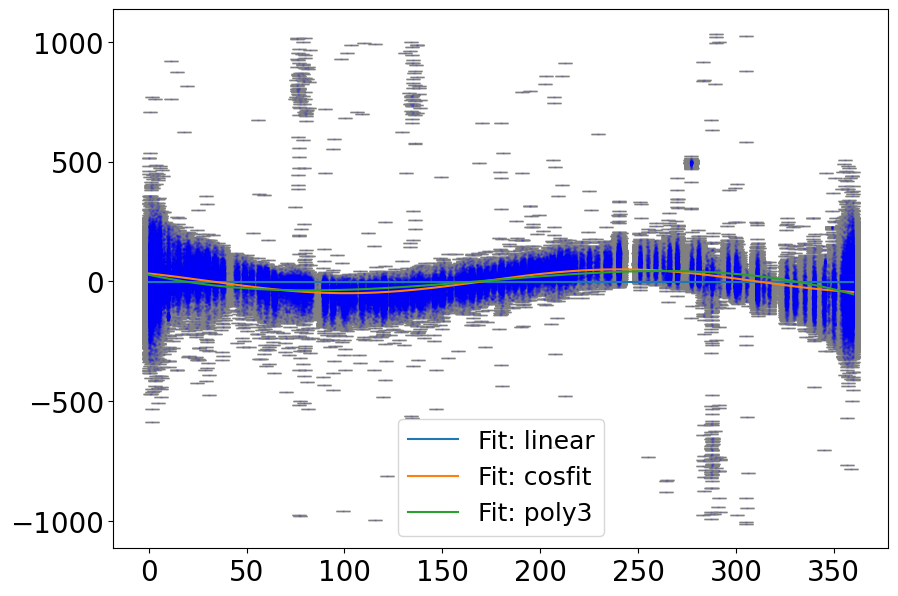

In [12]:
# FITTING - ANTHONY GERG
# --------------------------------------------
# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**23        
suspectbits = 2**16    
#=================================================================================
# Make the Mask

# GLAT >  20 and other 'bad' data.

ct1_ag = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     ((star['GLAT'] > -10)) & \
     ((star['GLAT'] < 10))  & \
     (~np.isnan(star['GLON'])==True) & \
     (~np.isnan(star['VHELIO_AVG'])==True)
cut1_ag = np.where(ct1_ag)[0]
print(np.max(star['GLON'][cut1_ag]),np.min(star['GLON'][cut1_ag]), np.max(star['VHELIO_AVG'][cut1_ag]),np.min(star['VHELIO_AVG'][cut1_ag]), )
#=================================================================================
## Linear Fit
slope, intercept = mcFit2(linear, star['GLON'][cut1_ag], star['VHELIO_AVG'][cut1_ag], star['GLON'][cut1_ag]/1000, \
                          star['VHELIO_AVG'][cut1_ag]/1000, p0=[0,0])
print(f'lin: {slope:.3f}, {intercept:.3f}')
#=================================================================================
## COS FIT (4 parameter)
polyA, polyB, polyC, polyD = mcFit4(cosfit, star['GLON'][cut1_ag], star['VHELIO_AVG'][cut1_ag], star['GLON'][cut1_ag]/1000, \
                         star['VHELIO_AVG'][cut1_ag]/1000,p0=[1,0.01,1,1])
print(f'cos: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}, {polyD:.3f}')

#=================================================================================
## POLY3 FIT (4 parameters)
bigpolyA, bigpolyB, bigpolyC, bigpolyD  = mcFit4(poly3, star['GLON'][cut1_ag], star['VHELIO_AVG'][cut1_ag], star['GLON'][cut1_ag]/1000,  \
                         star['VHELIO_AVG'][cut1_ag]/1000,p0=[1,1,1,1])
print(f'POLY3: {bigpolyA:.3f}, {bigpolyB:.3f}, {bigpolyC:.3f},{bigpolyD:.3f}')

#=================================================================================
# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['GLON'][cut1_ag],star['VHELIO_AVG'][cut1_ag],s=1,c='b',alpha=0.1)
ax1.errorbar((star['GLON'][cut1_ag]),star['VHELIO_AVG'][cut1_ag], yerr=abs(star['VERR'][cut1_ag]/1000), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(np.min(star['GLON'][cut1_ag]),np.max(star['GLON'][cut1_ag]),1000)

#=================================================================================
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#poly2 fit
ax1.plot(x_plot,cosfit(x_plot, polyA, polyB, polyC, polyD), label='Fit: cosfit')
#poly3 fit
ax1.plot(x_plot,poly3(x_plot, bigpolyA, bigpolyB, bigpolyC, bigpolyD), label='Fit: poly3')

plt.legend(loc='best', fontsize=18)
plt.show()
#1) Best fit values
#lin: -0.001, -3.966
#cos: -49.826, -0.023, 8.562, 0.585
#POLY3: -0.000, 0.014, -1.781,27.969
#2) Function fits best?
#Cosine is the best fit for this data
#3) Second fit?
# I would say there is a second population here, as above our main data area, there is a small cluster that cannot be accounted for

## DATA FIT 6

Fit a linear, an exponential, and a polynomial (poly3) functions and to the following selections of the data:
6. __Fit NVISITS vs.  VSCATTER (VERR)__ For NVISITS $>= 1$<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

69 1 1408.8365 0.0
LINEAR: 0.107, 0.453


C:\Users\gergy\AppData\Local\Temp\ipykernel_17436\2075752156.py:21: RuntimeWarning: overflow encountered in exp
  return a*np.exp(b*x + c) + d
C:\Users\gergy\AppData\Local\Temp\ipykernel_17436\2075752156.py:21: RuntimeWarning: overflow encountered in multiply
  return a*np.exp(b*x + c) + d


EXPO: 108996.856, -1696.044, -9218.881,0.830
POLY3: 0.000, -0.019, 0.381,-0.112


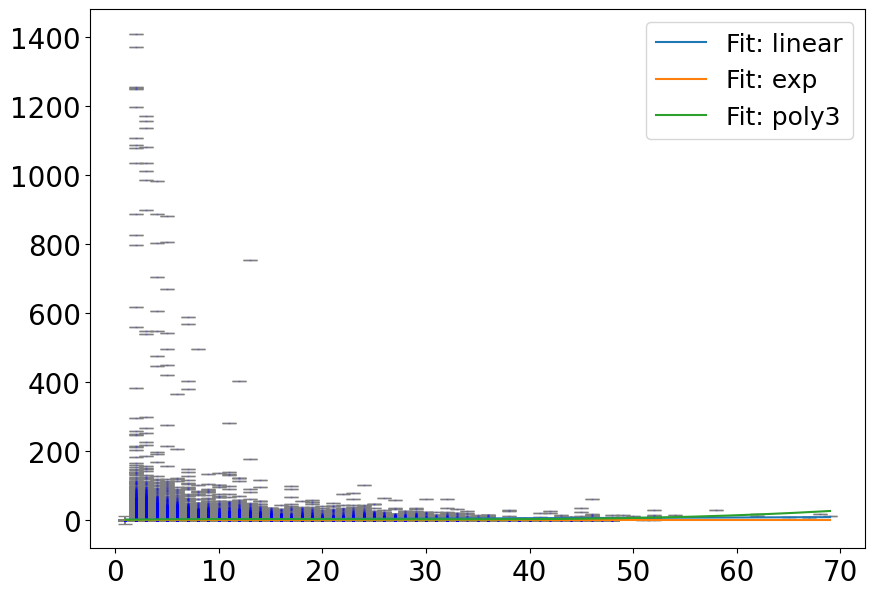

In [26]:
# FITTING - ANTHONY GERG
# --------------------------------------------
# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**23        
suspectbits = 2**16    
#=================================================================================
# Make the Mask

# GLAT >  20 and other 'bad' data.

ct1_ag = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     ((star['NVISITS'] >= 1)) & \
     (~np.isnan(star['NVISITS'])==True) & \
     (~np.isnan(star['VSCATTER'])==True)
cut1_ag = np.where(ct1_ag)[0]
print(np.max(star['NVISITS'][cut1_ag]),np.min(star['NVISITS'][cut1_ag]), np.max(star['VSCATTER'][cut1_ag]),np.min(star['VSCATTER'][cut1_ag]), )
#=================================================================================
## Linear Fit
slope, intercept = mcFit2(linear, star['NVISITS'][cut1_ag], star['VSCATTER'][cut1_ag], star['NVISITS'][cut1_ag]/1000, \
                          star['VSCATTER'][cut1_ag]/1000, p0=[1,1])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}') 
#=================================================================================
## EXPO FIT (3 parameter)
expA, expB, expC, expD  = mcFit4(exponential, star['NVISITS'][cut1_ag], star['VSCATTER'][cut1_ag], star['NVISITS'][cut1_ag]/1000, star['VSCATTER'][cut1_ag]/1000, p0=[ 10, -6, 0, 5])
print(f'EXPO: {expA:.3f}, {expB:.3f}, {expC:.3f},{expD:.3f}')

#=================================================================================
## POLY3 FIT (4 parameters)
bigpolyA, bigpolyB, bigpolyC, bigpolyD  = mcFit4(poly3, star['NVISITS'][cut1_ag], star['VSCATTER'][cut1_ag], star['NVISITS'][cut1_ag]/1000,  \
                         star['VSCATTER'][cut1_ag]/1000,p0=[1, 1, 1, 1])
print(f'POLY3: {bigpolyA:.3f}, {bigpolyB:.3f}, {bigpolyC:.3f},{bigpolyD:.3f}')

#=================================================================================
# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['NVISITS'][cut1_ag],star['VSCATTER'][cut1_ag],s=1,c='b',alpha=0.1)
ax1.errorbar((star['NVISITS'][cut1_ag]),star['VSCATTER'][cut1_ag],yerr=abs(star['VERR'][cut1_ag]/1000), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(np.min(star['NVISITS'][cut1_ag]),np.max(star['NVISITS'][cut1_ag]),1000)

#=================================================================================
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#poly2 fit
ax1.plot(x_plot,exponential(x_plot, expA, expB, expC, expD), label='Fit: exp')
#poly3 fit
ax1.plot(x_plot,poly3(x_plot, bigpolyA, bigpolyB, bigpolyC, bigpolyD), label='Fit: poly3')

plt.legend(loc='best', fontsize=18)
plt.show()
#What are the best-fit values of the parameters?
#Which fucntion fits the data best?
#Is there a second population? (Can you fit outliers with a reasonable linear trend?)
#1) Best fit values
#LINEAR: 0.000, 0.347
#EXPO: -1.000, -1.000, 2500.000,2.436
#POLY3: 0.000, -0.000, 0.002,-4.057
#2) Function fits best?
#For some reason, exponential refuses to work at all in my code, even when other people use my starting values and get numbers. I do not know the answer to this.
#None of them really fit the data well
#3) Second fit?
# I would assume that the data above a certain point must be considered as a second population.

## DATA FIT 7

Fit  a linear and a polynomial (poly2 AND poly3) functions and to the following selections of the data:
7. __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  NI\_FE (NI\_FE\_ERR)__<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

0.96824 -2.4679 2.966408 -2.9314027
lin: 0.013, 0.016
POLY2: 0.024, 0.038, 0.017
POLY3: -0.020, -0.017, 0.026,0.018


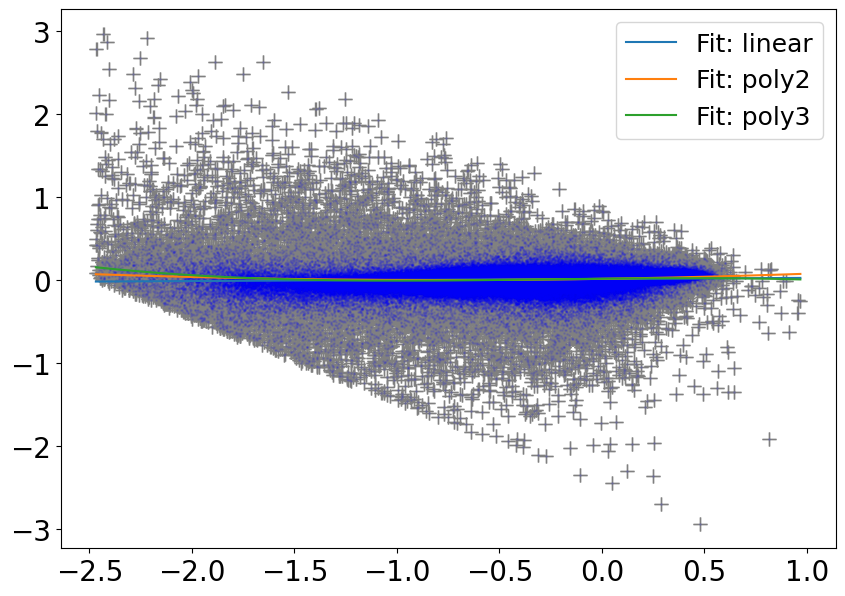

In [30]:
# FITTING - ANTHONY GERG
# --------------------------------------------
# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**23        
suspectbits = 2**16    
#=================================================================================
# Make the Mask

# GLAT >  20 and other 'bad' data.

ct1_ag = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (~np.isnan(star['FE_H'])==True) & \
     (~np.isnan(star['NI_FE'])==True)
cut1_ag = np.where(ct1_ag)[0]
print(np.max(star['FE_H'][cut1_ag]),np.min(star['FE_H'][cut1_ag]), np.max(star['NI_FE'][cut1_ag]),np.min(star['NI_FE'][cut1_ag]), )
#=================================================================================
## Linear Fit
slope, intercept = mcFit2(linear, star['FE_H'][cut1_ag], star['NI_FE'][cut1_ag], star['FE_H'][cut1_ag]/1000, \
                          star['NI_FE'][cut1_ag]/1000, p0=[0,0])
print(f'lin: {slope:.3f}, {intercept:.3f}')
#=================================================================================
## POLY2 FIT (3 parameter)
polyA, polyB, polyC,  = mcFit3(poly2, star['FE_H'][cut1_ag], star['NI_FE'][cut1_ag], star['FE_H'][cut1_ag]/1000, \
                         star['NI_FE'][cut1_ag]/1000,p0=[600,1,1])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

#=================================================================================
## POLY3 FIT (4 parameters)
bigpolyA, bigpolyB, bigpolyC, bigpolyD  = mcFit4(poly3, star['FE_H'][cut1_ag], star['NI_FE'][cut1_ag], star['FE_H'][cut1_ag]/1000,  \
                         star['NI_FE'][cut1_ag]/1000,p0=[1,1,1,1])
print(f'POLY3: {bigpolyA:.3f}, {bigpolyB:.3f}, {bigpolyC:.3f},{bigpolyD:.3f}')

#=================================================================================
# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['FE_H'][cut1_ag],star['NI_FE'][cut1_ag],s=1,c='b',alpha=0.1)
ax1.errorbar((star['FE_H'][cut1_ag]),star['NI_FE'][cut1_ag], xerr=(star['FE_H_ERR'][cut1_ag]/1000),
             yerr=abs(star['NI_FE_ERR'][cut1_ag]/1000), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(np.min(star['FE_H'][cut1_ag]),np.max(star['FE_H'][cut1_ag]),1000)

#=================================================================================
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC), label='Fit: poly2')
#poly3 fit
ax1.plot(x_plot,poly3(x_plot, bigpolyA, bigpolyB, bigpolyC, bigpolyD), label='Fit: poly3')

plt.legend(loc='best', fontsize=18)
plt.show()

#What are the best-fit values of the parameters?
#Which fucntion fits the data best?
#Is there a second population? (Can you fit outliers with a reasonable linear trend?)
#1) Best fit values
#lin: 0.013, 0.016
#POLY2: 0.024, 0.038, 0.017
#POLY3: -0.020, -0.017, 0.026,0.018
#2) Function fits best?
#They all fit pretty well
#3) Second fit?
# There is no second population